In [1]:
import datetime
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from modules.Utils.utils import loadFromDB, strategyTester, getFearAndGreedIndicator,computeStochasticLinearRegression
from modules.Utils.indicators import computeSuperTrend, addIndicators, computeLaggingLinearRegression, computeTrixIndicator, generateDatesFeatures


from random import randint
from bokeh.plotting import figure
from bokeh.io import push_notebook,show, output_notebook
from bokeh.models import HoverTool, Band, ColumnDataSource,Span
from bokeh.layouts import row, column
output_notebook()

import numpy as np
from scipy.fft import fft
import matplotlib.pyplot as plt
from PyEMD import EMD,CEEMDAN, EEMD
from sklearn.feature_selection import mutual_info_regression

Loading BokehJS ...

In [2]:
def computeEMD(df,col:str="Close"):
    def emd(signal):
        return EMD(DTYPE=np.float16, spline_kind='cubic')(signal.values)
    def phase_spectrum(imfs):
        imfs_p = []
        for i, imf in enumerate(imfs):
            trans = fft(imf)
            imfs_p.append(np.arctan(trans.imag / trans.real))           
        return imfs_p
    def phase_mi(phases):
        return np.array([mutual_info_regression(phases[i].reshape(-1, 1), phases[i+1])[0] for i in range(len(phases)-1)])
    def divide_signal(signal, imfs, mis, cutoff=0.75):
        cut_point = np.where(mis > cutoff)[0][0]
        return np.sum(imfs[:cut_point], axis=0), np.sum(imfs[cut_point:], axis=0)
    imfs = emd(df[col])

    stochastic_component, deterministic_component = divide_signal(df[col], imfs, phase_mi(phase_spectrum(imfs)),cutoff=0.96)
    df['EMD_S']=stochastic_component
    df['EMD_D']=deterministic_component
    return df

In [158]:
SYMBOL= 'BTC'
df = loadFromDB(f'./data/1h/{SYMBOL}-USDT.csv')
df = addIndicators(df,derivative=True, b_engulfings=True)
df = computeLaggingLinearRegression(df, 'Close',20, False,derivative=False)
df = computeStochasticLinearRegression(df,"Close")
df = computeTrixIndicator(df, col='Close')
df = generateDatesFeatures(df)
df = computeEMD(df)
#df = getFearAndGreedIndicator(df)
df.dropna(inplace=True)
print(df.shape)
print(df.columns)
df.head()

(23184, 37)
Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Timestamp', 'High_Low_diff',
       'EMA20', 'EMA50', 'EMA100', 'EMA200', 'MACD', 'Stoch_RSI', 'Vortex',
       'Bollinger_low', 'Bollinger_high', 'ADX', 'ATR', 'CCI', 'OVB',
       'OVB_EMA200', 'EVM', 'Bullish_engulfing', 'Bearish_engulfing', 'Slope',
       'B_MLR_coefs', 'Stochastic_prediction', 'Trix', 'Trix_histo', 'Month',
       'Year', 'Week', 'Hour', 'Year_sin', 'Year_cos', 'EMD_S', 'EMD_D'],
      dtype='object')


,Open,High,Low,Close,Volume,Timestamp,High_Low_diff,EMA20,EMA50,EMA100,...,Trix,Trix_histo,Month,Year,Week,Hour,Year_sin,Year_cos,EMD_S,EMD_D
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-12 04:00:00,8095.00,8110.92,8065.62,8091.33,963.637569,1578798000,45.30,8089.782443,8048.379011,7976.638385,...,8102.613890,-0.052148,1,2020,2,4,0.188807,0.982014,-43.614483,8134.944483
2020-01-12 05:00:00,8090.70,8105.00,8071.20,8073.79,711.211749,1578801600,33.80,8088.259353,8049.375521,7978.562179,...,8101.261583,-0.048403,1,2020,2,5,0.189511,0.981879,-57.932028,8131.722028
2020-01-12 06:00:00,8073.03,8110.92,8070.98,8106.05,997.127263,1578805200,39.94,8089.953701,8051.598049,7981.086690,...,8099.943496,-0.041874,1,2020,2,6,0.190215,0.981743,-22.176112,8128.226112
2020-01-12 07:00:00,8105.96,8153.84,8080.01,8083.84,2509.947391,1578808800,73.83,8089.371444,8052.862440,7983.121409,...,8098.651182,-0.036312,1,2020,2,7,0.190918,0.981606,-40.603638,8124.443638
2020-01-12 08:00:00,8083.43,8110.00,8080.45,8097.51,867.095068,1578812400,29.55,8090.146544,8054.613324,7985.386530,...,8097.497336,-0.030390,1,2020,2,8,0.191622,0.981469,-22.858759,8120.368759


In [183]:
from typing import Union
from joblib import dump, load

class StandardNormalizer():
    def __init__(self)->None:
        self._mean = None
        self._std = None

    def fit_transform(self,df:pd.DataFrame)->pd.DataFrame:
        self.fit(df)
        return self.transform(df)

    def fit(self, df:pd.DataFrame)->None:
        self._mean = df.mean()
        self._std = df.std()

    def transform(self, df:pd.DataFrame)->pd.DataFrame:
        return (df - self._mean) / self._std

    def inverse_transform(self,df:pd.DataFrame)->pd.DataFrame:
        return df * self._std + self._mean

    def inverse_transform_single(self,data:Union[pd.DataFrame,np.ndarray],corresponding_column:str='Close')->pd.DataFrame:
        return data * self._std[corresponding_column] + self._mean[corresponding_column]


scaler = StandardNormalizer()
train_df_test = scaler.fit_transform(df)
scaler.inverse_transform(train_df_test)


,Open,High,Low,Close,Volume,Timestamp,High_Low_diff,EMA20,EMA50,EMA100,...,Trix,Trix_histo,Month,Year,Week,Hour,Year_sin,Year_cos,EMD_S,EMD_D
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-12 04:00:00,8095.00,8110.92,8065.62,8091.33,963.637569,1.578798e+09,45.30,8089.782443,8048.379011,7976.638385,...,8102.613890,-0.052148,1.0,2020.0,2.0,4.0,0.188807,0.982014,-43.614483,8134.944483
2020-01-12 05:00:00,8090.70,8105.00,8071.20,8073.79,711.211749,1.578802e+09,33.80,8088.259353,8049.375521,7978.562179,...,8101.261583,-0.048403,1.0,2020.0,2.0,5.0,0.189511,0.981879,-57.932028,8131.722028
2020-01-12 06:00:00,8073.03,8110.92,8070.98,8106.05,997.127263,1.578805e+09,39.94,8089.953701,8051.598049,7981.086690,...,8099.943496,-0.041874,1.0,2020.0,2.0,6.0,0.190215,0.981743,-22.176112,8128.226112
2020-01-12 07:00:00,8105.96,8153.84,8080.01,8083.84,2509.947391,1.578809e+09,73.83,8089.371444,8052.862440,7983.121409,...,8098.651182,-0.036312,1.0,2020.0,2.0,7.0,0.190918,0.981606,-40.603638,8124.443638
2020-01-12 08:00:00,8083.43,8110.00,8080.45,8097.51,867.095068,1.578812e+09,29.55,8090.146544,8054.613324,7985.386530,...,8097.497336,-0.030390,1.0,2020.0,2.0,8.0,0.191622,0.981469,-22.858759,8120.368759
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-05 08:00:00,19726.04,19802.00,19703.98,19787.20,8805.061610,1.662358e+09,98.02,19836.537771,19851.082414,19918.624566,...,19843.560142,-0.002216,9.0,2022.0,36.0,8.0,-0.900073,-0.435739,6.380991,19780.819009
2022-09-05 09:00:00,19786.75,19797.42,19706.41,19750.00,8581.219320,1.662361e+09,91.01,19828.296078,19847.118397,19915.285466,...,19843.963660,-0.012890,9.0,2022.0,36.0,9.0,-0.900385,-0.435094,-33.808754,19783.808754
2022-09-05 10:00:00,19750.51,19792.76,19721.78,19781.65,7396.879130,1.662365e+09,70.98,19823.853595,19844.551009,19912.639219,...,19842.869286,-0.021030,9.0,2022.0,36.0,10.0,-0.900697,-0.434449,-5.028390,19786.678390


In [184]:
dump(scaler,f'./models/standard_normalizer_{SYMBOL}.save')

['./models/standard_normalizer_BTC.save']

In [159]:
train_df =scaler.fit_transform(df)
def split_sequence(sequence,
                    look_back,
                    forecast_horizon,
                    coverage,
                    column_labels=['EMA20']):
    X, y = [], []
    for i in range(len(sequence)): 
        lag_end = i + look_back
        forecast_end = lag_end + forecast_horizon
        if forecast_end > len(sequence):
            break
        X.append(sequence.iloc[i:lag_end])
        y.append(sequence.iloc[lag_end-coverage:forecast_end][column_labels])
    return np.array(X), np.array(y)

Open                     3.038011e+04
High                     3.055338e+04
Low                      3.019627e+04
Close                    3.038062e+04
Volume                   3.134034e+03
Timestamp                1.620605e+09
High_Low_diff            3.571159e+02
EMA20                    3.037579e+04
EMA50                    3.036814e+04
EMA100                   3.035518e+04
EMA200                   3.032792e+04
MACD                    -3.160583e-04
Stoch_RSI                5.117783e-01
Vortex                   2.121553e-02
Bollinger_low            3.109568e+04
Bollinger_high           2.965589e+04
ADX                      2.786684e+01
ATR                      2.345419e+01
CCI                      4.776730e+00
OVB                      5.682699e+05
OVB_EMA200               5.670281e+05
EVM                     -5.931731e+07
Bullish_engulfing        3.765528e-02
Bearish_engulfing        3.575742e-02
Slope                    5.040429e-01
B_MLR_coefs              1.382883e-04
Stochastic_p

In [160]:
INPUT_STEPS = 60
OUTPUT_STEPS = 20
COVERAGE_STEPS = 20
OUTPUT_SIZE = COVERAGE_STEPS+OUTPUT_STEPS

X,y = split_sequence(train_df,INPUT_STEPS,OUTPUT_STEPS,COVERAGE_STEPS,column_labels=['B_MLR_coefs'])

# LSTM

In [161]:

lstm_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=False),
    tf.keras.layers.Dense(OUTPUT_SIZE*1,kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Reshape([OUTPUT_SIZE, 1])
])

lstm_model.compile(loss=tf.keras.losses.MeanSquaredError(),
            optimizer=tf.keras.optimizers.Adam(0.0005),
            metrics=[tf.keras.metrics.MeanAbsoluteError()])

history = lstm_model.fit(X,y,
                    epochs=10,
                    validation_split=0.2,
                    batch_size=128,
                    shuffle=True,
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                        verbose=1,
                                                       patience=3,
                                                       mode='min',
                                                       restore_best_weights=True)],
                    use_multiprocessing=True)


Epoch 1/10
145/145 [==============================] - 7s 40ms/step - loss: 0.8272 - mean_absolute_error: 0.5316 - val_loss: 0.3536 - val_mean_absolute_error: 0.3926
Epoch 2/10
145/145 [==============================] - 5s 38ms/step - loss: 0.4478 - mean_absolute_error: 0.3929 - val_loss: 0.2624 - val_mean_absolute_error: 0.3525
Epoch 3/10
145/145 [==============================] - 5s 38ms/step - loss: 0.3072 - mean_absolute_error: 0.3276 - val_loss: 0.2236 - val_mean_absolute_error: 0.3274
Epoch 4/10
145/145 [==============================] - 5s 38ms/step - loss: 0.2469 - mean_absolute_error: 0.2939 - val_loss: 0.2052 - val_mean_absolute_error: 0.3128
Epoch 5/10
145/145 [==============================] - 5s 38ms/step - loss: 0.2138 - mean_absolute_error: 0.2737 - val_loss: 0.1959 - val_mean_absolute_error: 0.3051
Epoch 6/10
145/145 [==============================] - 6s 38ms/step - loss: 0.1898 - mean_absolute_error: 0.2597 - val_loss: 0.1910 - val_mean_absolute_error: 0.3023
Epoch 7/10

# CONV

In [166]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.MaxPooling1D(pool_size=2, strides=1, padding='valid', data_format='channels_last'),
    tf.keras.layers.Lambda(lambda x: x[:, -3:, :]),
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(3)),
    tf.keras.layers.Dense(OUTPUT_SIZE*1,kernel_initializer=tf.initializers.zeros(),),
    tf.keras.layers.Reshape([OUTPUT_SIZE, 1])
])


conv_model.compile(loss=tf.keras.losses.MeanSquaredError(),
            optimizer=tf.keras.optimizers.Adam(0.00005),
            metrics=[tf.keras.metrics.MeanAbsoluteError()])

            
history = conv_model.fit(X,y,
                    epochs=50,
                    validation_split=0.2,
                    batch_size=128,
                    shuffle=True,
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                        verbose=1,
                                                       patience=8,
                                                       mode='min',
                                                       restore_best_weights=True)],
                    use_multiprocessing=True)


Epoch 1/50
145/145 [==============================] - 1s 7ms/step - loss: 0.9901 - mean_absolute_error: 0.5936 - val_loss: 0.5303 - val_mean_absolute_error: 0.4878
Epoch 2/50
145/145 [==============================] - 1s 6ms/step - loss: 0.7019 - mean_absolute_error: 0.4988 - val_loss: 0.3685 - val_mean_absolute_error: 0.4091
Epoch 3/50
145/145 [==============================] - 1s 6ms/step - loss: 0.5089 - mean_absolute_error: 0.4289 - val_loss: 0.2970 - val_mean_absolute_error: 0.3742
Epoch 4/50
145/145 [==============================] - 1s 6ms/step - loss: 0.4174 - mean_absolute_error: 0.3896 - val_loss: 0.2595 - val_mean_absolute_error: 0.3536
Epoch 5/50
145/145 [==============================] - 1s 6ms/step - loss: 0.3643 - mean_absolute_error: 0.3642 - val_loss: 0.2371 - val_mean_absolute_error: 0.3398
Epoch 6/50
145/145 [==============================] - 1s 6ms/step - loss: 0.3325 - mean_absolute_error: 0.3482 - val_loss: 0.2255 - val_mean_absolute_error: 0.3321
Epoch 7/50
145/1

# Test

In [167]:
pred_lstm = lstm_model.predict(X)
pred_conv = conv_model.predict(X)

723/723 [==============================] - 1s 2ms/step


In [168]:
lstm_model.save(f'./models/{SYMBOL}_lstm_model.h5')
conv_model.save(f'./models/{SYMBOL}_conv_model.h5')

In [178]:
ind = randint(0,len(X)-1)
print(ind)

p = figure(title=f"Comparaison", x_axis_label='time', y_axis_label='value ($)',width=1500, height=600,)
# Add the HoverTool to the figure
p.add_tools(HoverTool(
    tooltips=[
    ("Price", "@y{0.00} $"),
], formatters={
        '$x': 'datetime',
        '$y' : 'printf',
    },
    mode='vline'
))
p.line(list(range(len(y[ind]))), (pred_conv[ind].reshape(OUTPUT_SIZE)+ pred_lstm[ind].reshape(OUTPUT_SIZE))/2, legend_label="LSTM x Conv Prediction", line_width=2, color='green')
p.line(list(range(len(y[ind]))), pred_lstm[ind].reshape(OUTPUT_SIZE), legend_label="LSTM Prediction", line_width=2, color='orange',line_dash='dashed',alpha=.3)
p.line(list(range(len(y[ind]))), pred_conv[ind].reshape(OUTPUT_SIZE), legend_label="Conv Prediction", line_width=2, color='red',line_dash='dashed',alpha=.3)
p.line(list(range(len(y[ind]))), y[ind].reshape(OUTPUT_SIZE), legend_label="B_MLR_coefs", line_width=2, )
vline = Span(location=COVERAGE_STEPS, dimension='height', line_color='black', line_width=2,line_dash='dashed')
p.renderers.extend([vline])
p.legend.location = "top_left"

show(p)

21034


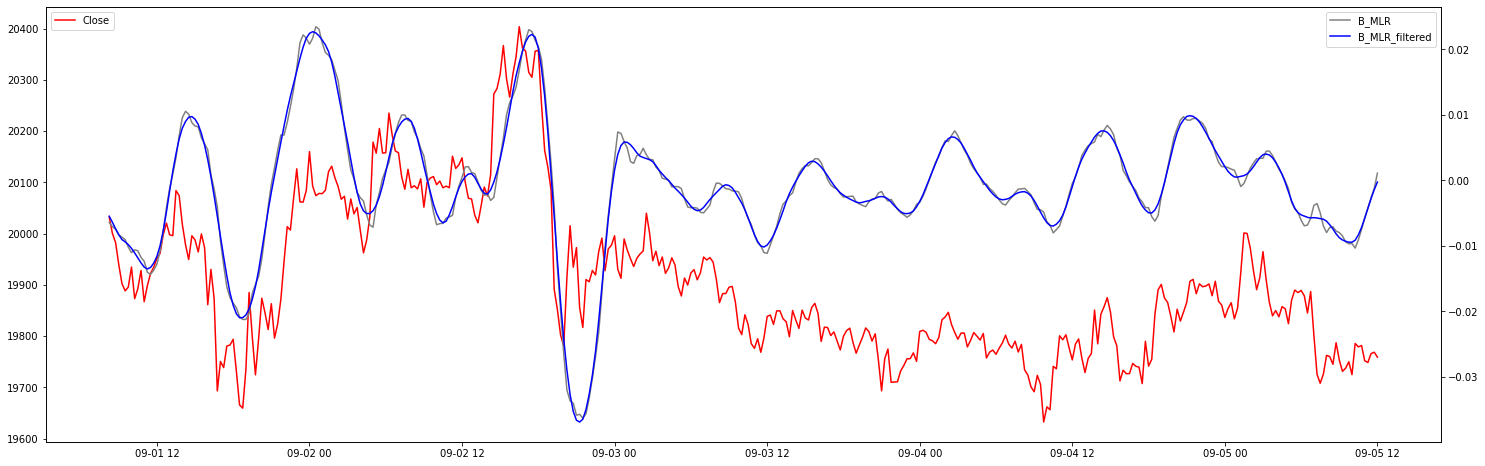

In [147]:
from scipy.signal import savgol_filter

df['B_MLR_coefs_denoised'] = savgol_filter(df.B_MLR_coefs.values, 15, 2, mode='nearest')
fig, ax_left = plt.subplots(1, figsize=(25,8))
ax_right =[]

ax_right = ax_left.twinx()

ax_left.plot(df.Close[-400:], color='red',label='Close')
ax_right.plot(df.B_MLR_coefs[-400:], color='gray',label='B_MLR')
ax_right.plot(df.B_MLR_coefs_denoised[-400:], color='blue',label='B_MLR_filtered')
ax_left.legend(loc="upper left")
ax_right.legend(loc="upper right")


In [31]:
df['B_MLR_coefs_denoised_diff'] = df.B_MLR_coefs_denoised.diff(1)
df.dropna(inplace=True)

In [32]:
def buyCondition(row:pd.Series, previous_row:pd.Series=None)->bool:
    return True if row.B_MLR_coefs_denoised_diff>0 else False

def sellCondition(row:pd.Series, previous_row:pd.Series=None)->bool:
    return True if row.B_MLR_coefs_denoised_diff<0 else False

strategyTester(df,buyCondition,sellCondition,equity=1000)

# Tuning

In [ ]:
#import keras_tuner
#
#def build_model(hp):
#    CONV_WIDTH = hp.Int("CONV_WIDTH", min_value=2, max_value=6, step=2)
#    model = tf.keras.Sequential([
#        # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
#        tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
#        # Shape => [batch, 1, conv_units]
#        tf.keras.layers.Conv1D(256, activation=hp.Choice("activation", ["relu", "tanh"]), kernel_size=(CONV_WIDTH)),
#        # Shape => [batch, 1,  out_steps*features]
#        tf.keras.layers.Dense(OUTPUT_SIZE*1,
#                            kernel_initializer=tf.initializers.zeros()),
#        # Shape => [batch, out_steps, features]
#        tf.keras.layers.Reshape([OUTPUT_SIZE, 1])
#    ])
#
#    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
#                                                        patience=8,
#                                                        mode='min')
#
#    lr = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
#    model.compile(loss=tf.keras.losses.MeanSquaredError(),
#                optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
#                metrics=[tf.keras.metrics.MeanAbsoluteError()])
#    return model
#
#
##build_model(keras_tuner.HyperParameters())
#
#tuner = keras_tuner.RandomSearch(
#    hypermodel=build_model,
#    objective="val_mean_absolute_error",
#    max_trials=10,
#    executions_per_trial=1,
#    overwrite=True,
#    #directory="my_dir",
#    #project_name="helloworld",
#)
#tuner.search_space_summary()
#
#
#tuner.search(X,
#            y,
#            epochs=30,
#            validation_split=0.2,
#            #callbacks=[early_stopping],
#            use_multiprocessing=True)
#            
#models = tuner.get_best_models(num_models=2)
#model = models[0]

In [59]:
class TFLiteModel:
    """Wrapper class for loading and using a tflite model."""
    def __init__(self, model_path: str)-> None:
        """Constructor : load tflite model.

        Args:
            model_path (str): The path to the model.
        """
        self._interpreter = tf.lite.Interpreter(model_path=model_path)
        self._interpreter.allocate_tensors()
        
    def predict(self, input_data:np.ndarray,unscale_data:bool=False) -> np.ndarray:   
             
        input_details = self._interpreter.get_input_details()
        output_details = self._interpreter.get_output_details()
        assert input_data.shape == tuple(input_details[0]['shape'])
        
        self._interpreter.set_tensor(input_details[0]['index'], np.float32(input_data))
        self._interpreter.invoke()
        output_data = self._interpreter.get_tensor(output_details[0]['index'])
        return output_data

In [72]:
class TFModel:
    """Wrapper class for loading and using a tflite model."""
    def __init__(self, model_path: str)-> None:
        """Constructor : load tflite model.

        Args:
            model_path (str): The path to the model.
        """
        #self._interpreter = Interpreter(model_path=model_path)
        self._model = tf.keras.models.load_model(model_path)

        
    def predict(self, input_data:np.ndarray,unscale_data:bool=False) -> np.ndarray:   
        assert input_data.shape[1] == self._model.input_shape[1]
        assert input_data.shape[2] == self._model.input_shape[2]
        output_data = self._model.predict(input_data)
        return output_data

lstm_model_loaded = TFModel(f'./Models/BTC_lstm_model.h5')
lstm_model_loaded.predict(np.float32(X[9683].reshape(1,60,38)))

1/1 [==============================] - 0s 312ms/step


array([[[ 1.6916391e-02],
        [ 5.9132818e-03],
        [-4.5452788e-03],
        [-1.1907976e-02],
        [-1.1918915e-02],
        [ 7.2451495e-04],
        [ 2.7115535e-02],
        [ 7.0385814e-02],
        [ 1.3892455e-01],
        [ 2.2964500e-01],
        [ 3.4193736e-01],
        [ 4.7728604e-01],
        [ 6.2671155e-01],
        [ 7.7918184e-01],
        [ 9.2151755e-01],
        [ 1.0459557e+00],
        [ 1.1578847e+00],
        [ 1.2516888e+00],
        [ 1.3165712e+00],
        [ 1.3439410e+00],
        [ 1.3241885e+00],
        [ 1.2188883e+00],
        [ 1.0429329e+00],
        [ 8.1587952e-01],
        [ 5.3970832e-01],
        [ 2.2437508e-01],
        [-1.2387420e-01],
        [-4.9179712e-01],
        [-8.6253297e-01],
        [-1.2226083e+00],
        [-1.5615782e+00],
        [-1.8622689e+00],
        [-2.1124802e+00],
        [-2.2995503e+00],
        [-2.4196582e+00],
        [-2.4709282e+00],
        [-2.4529319e+00],
        [-2.3751953e+00],
        [-2.

In [60]:
conv_model=tf.keras.models.load_model(f'./models/{SYMBOL}_conv_model.h5')
lstm_model=tf.keras.models.load_model(f'./models/{SYMBOL}_lstm_model.h5')
predictions = []
# Convert the model
for model,name in zip([conv_model,lstm_model],['conv','lstm']):
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.allow_custom_ops = True
    converter.target_spec.supported_ops = [
      tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
      tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
    ]
    tflite_model = converter.convert()
    # Save the model.
    with open(f'./models/{SYMBOL}_{name}.tflite', 'wb') as f:
      f.write(tflite_model)

    current_model = TFLiteModel(f'./models/{SYMBOL}_{name}.tflite')
    predictions.append(current_model.predict(np.float32(X[9683].reshape(1,60,38))).reshape(40))


INFO:tensorflow:Assets written to: C:\Users\admin\AppData\Local\Temp\tmpfrkj20xo\assets


INFO:tensorflow:Assets written to: C:\Users\admin\AppData\Local\Temp\tmpfrkj20xo\assets


INFO:tensorflow:Assets written to: C:\Users\admin\AppData\Local\Temp\tmpm8wjg3ll\assets


INFO:tensorflow:Assets written to: C:\Users\admin\AppData\Local\Temp\tmpm8wjg3ll\assets


In [62]:
p = figure(title=f"Comparaison", x_axis_label='time', y_axis_label='value ($)',width=1500, height=600,)
# Add the HoverTool to the figure
p.add_tools(HoverTool(
    tooltips=[
    ("Price", "@y{0.00} $"),
], formatters={
        '$x': 'datetime',
        '$y' : 'printf',
    },
    mode='vline'
))
p.line(list(range(len(predictions[1]))), (predictions[1].reshape(OUTPUT_SIZE)+ predictions[0].reshape(OUTPUT_SIZE))/2, legend_label="LSTM x Conv Prediction", line_width=2, color='orange')
p.line(list(range(len(predictions[1]))), y[9683].reshape(OUTPUT_SIZE), legend_label="B_MLR_coefs", line_width=2, )
vline = Span(location=COVERAGE_STEPS, dimension='height', line_color='black', line_width=2,line_dash='dashed')
p.renderers.extend([vline])
p.legend.location = "top_left"
show(p)

In [ ]:
import numpy as np
import tensorflow as tf

# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="./model.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test model on random input data.
input_shape = input_details[0]['shape']
input_data = np.float32(X)#np.array(np.float32(X[-1].reshape(1,60,38)), dtype=np.float32)
interpreter.set_tensor(input_details[0]['index'],np.float32(X[-1].reshape(1,60,38)))
interpreter.invoke()

# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data)

In [139]:
df.B_MLR_coefs.values


array([ 2.81817043e-04,  1.80724728e-04, -9.02046784e-05, ...,
        6.11131997e-05, -2.60066834e-05, -8.37984545e-04])

In [140]:
output_data[0].reshape(40)*df.B_MLR_coefs.std()+df.B_MLR_coefs.mean()

array([-0.00382623, -0.00524257, -0.00597959, -0.00604487, -0.00516733,
       -0.00501163, -0.00449779, -0.00386011, -0.00400485, -0.00375702,
       -0.00344385, -0.00304197, -0.00313159, -0.00264799, -0.00356175,
       -0.00303906, -0.00250716,  0.00064374,  0.00176276,  0.00520646,
        0.00802915,  0.01000458,  0.00997781,  0.01054154,  0.01024669,
        0.00866046,  0.00766866,  0.0082461 ,  0.00879483,  0.0097452 ,
        0.01036937,  0.00972864,  0.00815944,  0.00612878,  0.00232412,
       -0.00146018, -0.00498969, -0.00818477, -0.01031332, -0.01007655],
      dtype=float32)

In [144]:
np.vstack([df.B_MLR_coefs.values
,output_data[0].reshape(40)*df.B_MLR_coefs.std()+df.B_MLR_coefs.mean()])

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 23184 and the array at index 1 has size 40